In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [6]:
tf.random.set_seed(123)

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123
)

In [9]:
# Step 2: Build the training/testing pipelines
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label  # tf.one_hot(label, 10)

In [10]:
X_train, y_train = normalize_img(X_train, y_train)
X_val, y_val = normalize_img(X_val, y_val)
X_test, y_test = normalize_img(X_test, y_test)

In [11]:
# Step 3: Create the model
inp = tf.keras.layers.Input(shape=(28, 28, 1))
b = tf.keras.layers.Flatten()(inp)
b = tf.keras.layers.Dense(16, activation="relu")(b)
out = tf.keras.layers.Dense(10, activation="softmax")(b)

model = tf.keras.models.Model(inp, out)

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,730 (49.73 KB)

 Trainable params: 12,730 (49.73 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [13]:
# Step 4: Train the model
hist = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=tf.keras.callbacks.EarlyStopping(patience=2),
)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.7522 - loss: 0.8167 - val_accuracy: 0.9170 - val_loss: 0.2864
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/step - accuracy: 0.9252 - loss: 0.2657 - val_accuracy: 0.9292 - val_loss: 0.2492
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.9352 - loss: 0.2294 - val_accuracy: 0.9341 - val_loss: 0.2319
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.9401 - loss: 0.2087 - val_accuracy: 0.9372 - val_loss: 0.2211
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.9435 - loss: 0.1939 - val_accuracy: 0.9398 - val_loss: 0.2091
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.9480 - loss: 0.1794 - val_accuracy: 0.9416 - val_loss: 0.1999
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - accuracy: 0.9513 - loss: 0.1678 - val_accuracy: 0.9427 - val_loss: 0.1942
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.9537 -

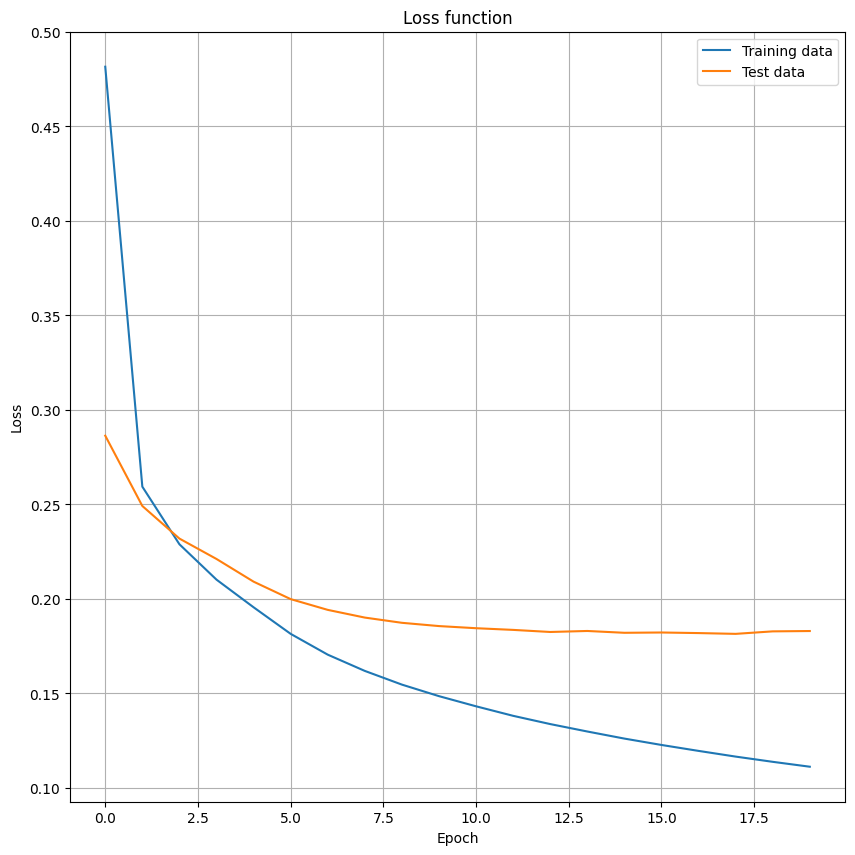

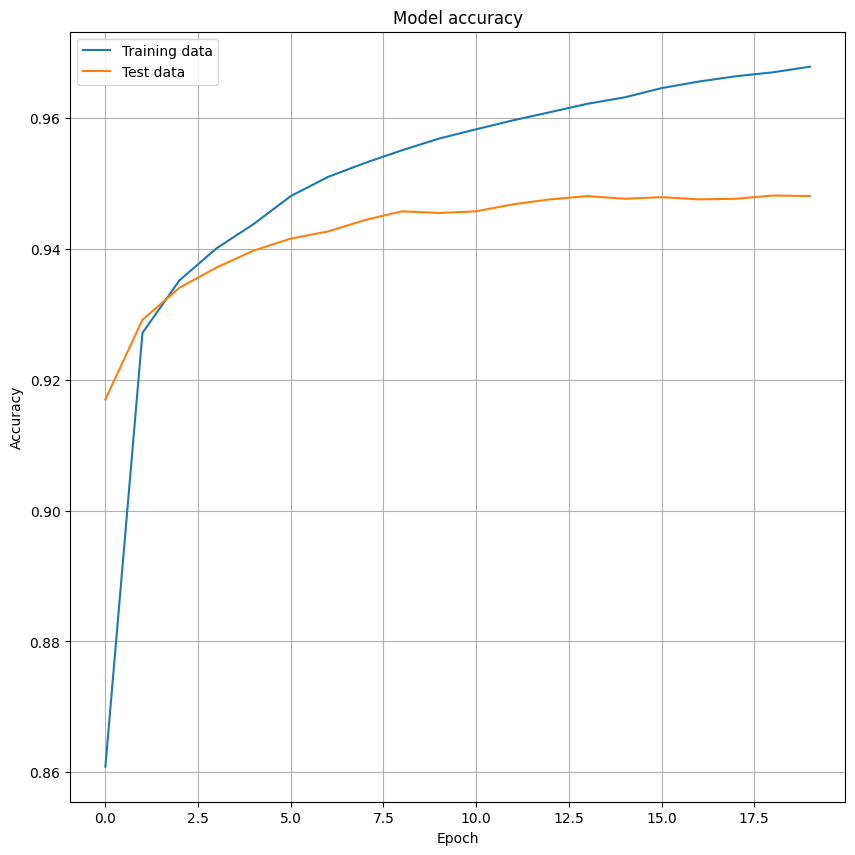

In [14]:
# Plot the training progress
fig = plt.figure(figsize=(10, 10))
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss function")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid()
plt.legend(["Training data", "Test data"])
plt.show()

fig = plt.figure(figsize=(10, 10))
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.grid()
plt.legend(["Training data", "Test data"])
plt.show()

In [15]:
# Step 5/6: Evaluate the model (we do no hyperparameter tuning here)
loss_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("Test Loss: {}".format(loss_accuracy[0]))
print("Test Accuracy: {}".format(loss_accuracy[1]))

Test Loss: 0.16419757902622223
Test Accuracy: 0.9516000151634216


### Introduction to Keras tuner

In [16]:
# We install Keras tuner
%pip install -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [17]:
import keras_tuner as kt

In [18]:
def build_model(hp):
    """
    hp: stands for hyperparameter
    """

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Flatten())
    number_hidden_layers = hp.Int("num_layers", 1, 3)
    for i in range(number_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                hp.Int("units", min_value=16, max_value=128, step=16),
                activation="relu",
                kernel_initializer="he_normal",
            )
        )

    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
    )

    return model

In [19]:
tuner = kt.Hyperband(build_model, objective="val_acc", overwrite=True)

In [20]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)

In [21]:
tuner.search(
    X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[stop_early]
)

Trial 24 Complete [00h 00m 04s]
val_acc: 0.9635833501815796

Best val_acc So Far: 0.9673333168029785
Total elapsed time: 00h 01m 26s


In [22]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [23]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

In [24]:
# Train the best model
hist = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=tf.keras.callbacks.EarlyStopping(patience=2),
)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.8652 - loss: 0.4369 - val_acc: 0.9593 - val_loss: 0.1360
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.9661 - loss: 0.1135 - val_acc: 0.9651 - val_loss: 0.1216
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.9758 - loss: 0.0768 - val_acc: 0.9656 - val_loss: 0.1245
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.9813 - loss: 0.0572 - val_acc: 0.9673 - val_loss: 0.1243


In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (32, 784)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 10)               │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,384 (1.54 MB)

 Trainable params: 134,794 (526.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 269,590 (1.03 MB)

In [26]:
# Evaluate the best model
loss_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("Test Loss: {}".format(loss_accuracy[0]))
print("Test Accuracy: {}".format(loss_accuracy[1]))

Test Loss: 0.11143451929092407
Test Accuracy: 0.9678000211715698
